In [20]:
import pandas as pd
import numpy as np
import sklearn
import torch
import time
import os
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys

# TODO: change this to the path where you have the project set up - it's necessary to load Python components from within the src/ directory
sys.path.insert(1, '/home/lmautner/music-classification-DL22/')

In [3]:
# TODO: copy a trained model with the right z-dimension here via the .ckpt file (use the best, not the last)
model = torch.load('ae.ckpt')

In [4]:
from src.models.components.ae import AE

module = AE(latent_space_dim=50)
full_dict = model['state_dict']
filtered_dict = dict([(key.replace('ae.', ''), full_dict[key]) for key in full_dict.keys() if key.startswith('ae.')])
filtered_dict

{'model_encode.0.weight': tensor([[-4.1198e-43, -4.2459e-43, -3.2790e-43,  ...,  5.3950e-43,
          -2.6905e-43,  3.8956e-43],
         [-8.1674e-36,  2.2365e-35,  2.3402e-43,  ..., -2.6832e-30,
           6.8892e-35, -2.5766e-33],
         [ 5.0827e-36, -5.6397e-36,  1.6029e-35,  ...,  2.7447e-31,
           6.1996e-24,  2.5466e-27],
         ...,
         [ 3.7695e-43,  2.1300e-43,  3.3739e-41,  ...,  6.4965e-38,
          -2.1647e-36, -1.2237e-31],
         [-9.5288e-40, -7.0214e-39, -2.2136e-40,  ...,  1.7933e-24,
          -1.0447e-29,  3.3547e-28],
         [ 2.4275e-23,  5.9069e-23, -2.8621e-20,  ...,  1.8772e-15,
          -5.9088e-15,  3.7525e-16]], device='cuda:0'),
 'model_encode.0.bias': tensor([ 9.1785e-43,  4.4982e-43, -8.8422e-43,  6.2616e-36, -8.5479e-44,
          5.6472e-43, -1.3032e-42,  1.0370e-42,  1.1169e-07,  1.3593e-43,
          6.5861e-43, -1.5975e-43, -4.1058e-43, -1.1196e-42, -1.4770e-42,
          3.2917e-42, -1.5400e-42, -7.4269e-44,  1.6633e-42,  2.834

In [5]:
module.load_state_dict(filtered_dict)
module.eval()

AE(
  (model_encode): Sequential(
    (0): Linear(in_features=518, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=200, bias=True)
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=50, bias=True)
  )
  (model_decode): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=200,

In [6]:
from typing import Tuple, List
from sklearn.preprocessing import LabelEncoder, StandardScaler
from src.datamodules.components.musical_features_dataset import MusicalFeaturesDataset


def read_data(data_dir: str) -> Tuple[LabelEncoder, MusicalFeaturesDataset]:
    features = pd.read_csv(f'{data_dir}/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])

    tracks = pd.read_csv(f'{data_dir}/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
    tracks['track', 'genre_top'] = tracks['track', 'genre_top'].astype('category')
    tracks = tracks[[('track', 'genre_top'), ('set', 'split')]].dropna()

    features = features.loc[[idx for idx in features.index if idx in tracks.index]]
    tracks = tracks.loc[[idx for idx in tracks.index if idx in features.index]]

    features = features.sort_index()
    tracks = tracks.sort_index()

    tracks = tracks[[('track', 'genre_top')]]
    labels = np.array(tracks).ravel()
    enc = LabelEncoder()
    labels = torch.tensor(enc.fit_transform(labels))

    feats = np.array(features)
    scaler = StandardScaler(copy=False)
    feats = torch.tensor(scaler.fit_transform(feats), dtype=torch.float32)

    return enc, MusicalFeaturesDataset(
        features=feats,
        genres=labels
    )

In [7]:
enc, dataset = read_data('../../data')

In [8]:
enc.classes_

array(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
       'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
       'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
      dtype=object)

In [9]:
z = module.model_encode(dataset.features)

In [10]:
z.shape

torch.Size([49598, 50])

In [11]:
pd.DataFrame(z.detach().numpy()).to_csv('z50.csv')

In [113]:
# TODO: run the 'tsne.py' script here - Jupyter always crashed for me when I tried to run TSNE in here

In [47]:
z_vis_df = pd.read_csv('z50_vis.csv', index_col=0)
z_vis = np.array(z_vis_df)
z_vis.shape

(49598, 2)

In [111]:
z_vis_x, z_vis_y = z_vis[:, 0], z_vis[:, 1]
labels = dataset.genres

labels_unique, labels_frequency = np.unique(labels, return_counts=True)
sorted_index_uniques = np.argsort(labels_frequency)[::-1]

sorted_labels = []
sorted_vx = []
sorted_vy = []
for siu in sorted_index_uniques:
    label_siu = labels_unique[siu]
    matching_indices = np.asarray(labels == label_siu).nonzero()[0]

    matching_indices = matching_indices[:int(.3 * len(matching_indices))]

    sorted_labels.extend(list(labels[matching_indices]))
    sorted_vx.extend(list(z_vis_x[matching_indices]))
    sorted_vy.extend(list(z_vis_y[matching_indices]))

labels = np.array(sorted_labels)
z_vis_x = np.array(sorted_vx)
z_vis_y = np.array(sorted_vy)

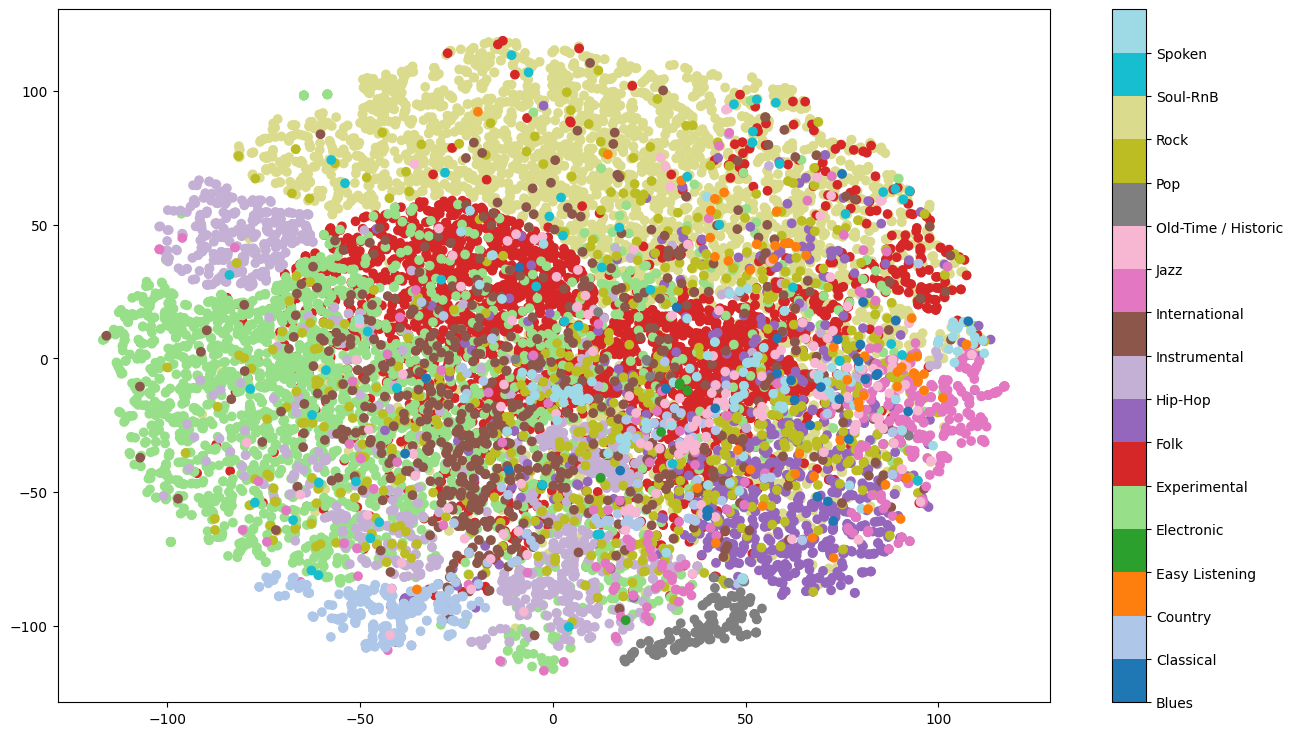

In [112]:
limit = -1
genres = 16
plt.figure(figsize=(16, 9))
plt.scatter(
    z_vis_x[:limit],
    z_vis_y[:limit],
    c=labels[:limit],
    cmap=matplotlib.colormaps['tab20'].resampled(genres)
)

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(genres))
cb.set_ticks(loc)
cb.set_ticklabels(enc.classes_)